# Sanity Check of FedLeak (CenterCrop Generator), Lung & Colon Cancer (LC25000)

Here is the sanity check on if FedLeak has been correctly trasferred.

We evaluate it with ***Lung & Colon Cancer (LC25000)***, with $5$ times sampling batch = $16$, reporting the best results in $5$ times recovery.
- *Evaluate times*: $5$.
- *Attack Target*: the averaged gradient from a sampled batch with $16$ datapoints.
- *How to sample*: the first $5$ batches from train-set, with `shuffle=False`.
- *Way to report*: PSNRs in $5$ times recovery, including the *max* value and the *median* value.

Codes are aligned with `sanity_check_centercrop_showcase.ipynb`, with `centercrop_generator.py` introduced.

### 🚩 1. Utils Importing

In [1]:
import warnings
warnings.filterwarnings("ignore")

import torch, torchvision, argparse, os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

try:
    import utils
    from criteria import *
    from utils import upscale, get_resnet18
    from centercrop_generator import FedLeak
except ModuleNotFoundError:
    # You only really need this safety net if you want to run these notebooks directly in the examples directory
    # Don't worry about this if you installed the package or moved the notebook to the main directory.
    os.chdir("..")
    
    import utils
    from criteria import *
    from utils import upscale, get_resnet18
    from centercrop_generator import FedLeak


def plot_images(images):
    plt.figure(figsize=(4, 3))
    
    images = images.clone().detach()
    images.mul(255).add_(0.5).clamp_(0, 255)
    images = images.to(dtype=torch.float32)

    grid_shape = int(torch.as_tensor(images.shape[0]).sqrt().ceil())
    _, axes = plt.subplots(grid_shape, grid_shape, figsize=(6, 6))
    for im, axis in zip(images, axes.flatten()):
        axis.imshow(im.permute(1, 2, 0).cpu())
        axis.axis("off")

    plt.show()


class ImageNet(torch.utils.data.Dataset):
    def __init__(self, dir="./imagenet/images", csv_path="./imagenet/images.csv", transforms=None):
        self.dir = dir
        self.csv = pd.read_csv(csv_path)
        self.transforms = transforms

    def __getitem__(self, index):
        img_obj = self.csv.loc[index]
        ImageID = img_obj['ImageId'] + '.png'
        Truelabel = img_obj['TrueLabel'] - 1
        img_path = os.path.join(self.dir, ImageID)
        pil_img = Image.open(img_path).convert('RGB')
        if self.transforms:
            data = self.transforms(pil_img)
        return data, Truelabel

    def __len__(self):
        return len(self.csv)

class NormalizedModel(torch.nn.Module):
    def __init__(self, model, mean, std, device):
        super(NormalizedModel, self).__init__()
        self.model = model
        self.resize_op = torchvision.transforms.Resize((224, 224))
        self.mean, self.std = mean.to(device), std.to(device)

    def forward(self, x):
        x = self.resize_op(x)
        x = (x - self.mean) / self.std
        return self.model(x)


def get_client_gradient(data, label, model, loss_fn):
    loss = loss_fn(model(data), label)
    grads = torch.autograd.grad(loss, model.parameters())
    return grads


@torch.jit.script
def l1_loss(x, y):
    return (x-y).abs().mean()


def l2_loss(x, y):
    return (x-y).norm(2)


@torch.jit.script
def cos_loss(x, y):
    mask = x.abs().detach() >= x.detach().flatten().abs().quantile(0.2).item() # 只保留最小的百分之多少
    x, y = x * mask, y * mask
    return -(x.flatten() * y.flatten()).sum() / (x.flatten().norm(2)+1e-8) / (y.flatten().norm(2)+1e-8)


@torch.jit.script
def combine_loss(x, y):
    mask = (y.abs() >= torch.quantile(y.abs(), 0.5).item()).float()
    x, y = mask * x, mask * y
    return l1_loss(x, y) + cos_loss(x, y)

### 🚩 2. Data Loading

In [2]:
seed = 2025
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
device = torch.device(f"cuda:1")
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((128, 128))
])

dataset = torchvision.datasets.ImageFolder(root="~/data/lung_colon_image_set/", transform=transform)
trainloader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=False)
loader_iter = iter(trainloader)

### 🚩 3. Attack for five times

In [3]:
# define utils
import statistics
def print_psnrs(psnrs):
    median_psnr = statistics.mean(psnrs)
    best_psnr = max(psnrs)
    print(f"BEST PSNR: {best_psnr:6.4f}")
    print(f"MEDIAN PSNR: {median_psnr:6.4f}")
    
    print("ALL PSNR: [", end="")
    for p in psnrs[0:-1]:
        print(f"{p:6.4f}, ", end="")
    print(f"{p:6.4f}]")

#### ⭕ 3.1 Times 1

True Data:


<Figure size 400x300 with 0 Axes>

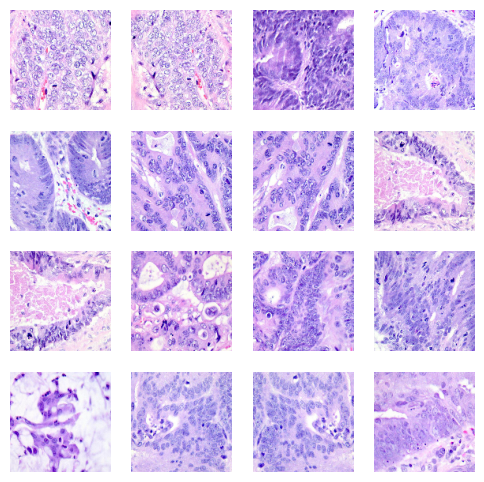

| It: 1 | Loss: -45.0802 | Time:   5.21s |


| It: 1001 | Loss: -60.9496 | Time: 562.28s |


| It: 2001 | Loss: -61.3145 | Time: 562.04s |


| It: 3001 | Loss: -61.4982 | Time: 562.84s |


| It: 4001 | Loss: -61.5983 | Time: 562.81s |


| It: 5001 | Loss: -61.6661 | Time: 559.80s |


| It: 6001 | Loss: -61.7257 | Time: 563.93s |


| It: 7001 | Loss: -61.7669 | Time: 562.57s |


| It: 8001 | Loss: -61.7938 | Time: 561.32s |


| It: 9001 | Loss: -61.8075 | Time: 561.30s |


| It: 1 | Loss: -43.3407 | Time:   0.58s |


| It: 1001 | Loss: -60.8939 | Time: 559.51s |


| It: 2001 | Loss: -61.3428 | Time: 560.47s |


| It: 3001 | Loss: -61.5071 | Time: 558.92s |


| It: 4001 | Loss: -61.6102 | Time: 561.51s |


| It: 5001 | Loss: -61.6793 | Time: 560.47s |


| It: 6001 | Loss: -61.7306 | Time: 561.96s |


| It: 7001 | Loss: -61.7745 | Time: 560.43s |


| It: 8001 | Loss: -61.8006 | Time: 560.59s |


| It: 9001 | Loss: -61.8128 | Time: 559.61s |


| It: 1 | Loss: -43.2703 | Time:   0.54s |


| It: 1001 | Loss: -60.4552 | Time: 562.31s |


| It: 2001 | Loss: -61.1447 | Time: 563.59s |


| It: 3001 | Loss: -61.4182 | Time: 562.47s |


| It: 4001 | Loss: -61.5417 | Time: 560.41s |


| It: 5001 | Loss: -61.6279 | Time: 559.08s |


| It: 6001 | Loss: -61.6943 | Time: 560.90s |


| It: 7001 | Loss: -61.7449 | Time: 561.28s |


| It: 8001 | Loss: -61.7784 | Time: 562.30s |


| It: 9001 | Loss: -61.7951 | Time: 561.89s |


| It: 1 | Loss: -43.4418 | Time:   0.42s |


| It: 1001 | Loss: -60.7553 | Time: 562.55s |


| It: 2001 | Loss: -61.2614 | Time: 560.94s |


| It: 3001 | Loss: -61.4638 | Time: 557.53s |


| It: 4001 | Loss: -61.5669 | Time: 561.66s |


| It: 5001 | Loss: -61.6474 | Time: 559.93s |


| It: 6001 | Loss: -61.7073 | Time: 563.43s |


| It: 7001 | Loss: -61.7524 | Time: 561.19s |


| It: 8001 | Loss: -61.7838 | Time: 562.01s |


| It: 9001 | Loss: -61.7982 | Time: 562.50s |


| It: 1 | Loss: -45.0677 | Time:   0.58s |


| It: 1001 | Loss: -60.7279 | Time: 549.28s |


| It: 2001 | Loss: -61.2314 | Time: 350.06s |


| It: 3001 | Loss: -61.4514 | Time: 351.35s |


| It: 4001 | Loss: -61.5654 | Time: 351.24s |


| It: 5001 | Loss: -61.6436 | Time: 349.76s |


| It: 6001 | Loss: -61.6993 | Time: 354.07s |


| It: 7001 | Loss: -61.7461 | Time: 351.14s |


| It: 8001 | Loss: -61.7778 | Time: 351.96s |


| It: 9001 | Loss: -61.7921 | Time: 352.09s |


BEST PSNR: 14.4212
MEDIAN PSNR: 13.7641
ALL PSNR: [13.4361, 14.1456, 13.3825, 13.4352, 13.4352]


<Figure size 400x300 with 0 Axes>

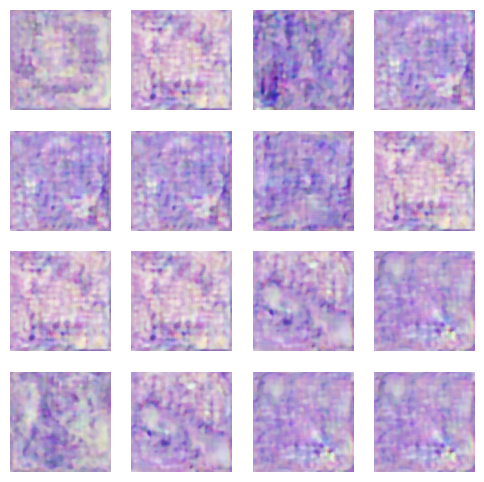

In [4]:
model = get_resnet18().to(device)
loss_func = torch.nn.CrossEntropyLoss()
data, label = next(loader_iter)
data, label = data.to(device), label.to(device)
client_grads = get_client_gradient(data, label, model, torch.nn.CrossEntropyLoss())
client_grads = [grad.clone() for grad in client_grads]
print(f"True Data:")
plot_images(data)

data = upscale(data)
best_ones_PSNR = torch.zeros_like(data)
best_ones_SSIM = torch.zeros_like(data)
best_ones_LPIPS = torch.zeros_like(data)
psnrs = []

for _ in range(5): # restart for better attack performance.
    recovered_images = FedLeak(client_grads, label, model, combine_loss, device=device)
    psnr = compute_psnr(data, recovered_images, False).mean().item()
    psnrs.append(psnr)
    best_ones_PSNR = update_best_ones(best_ones_PSNR, data, recovered_images, "PSNR")

print_psnrs(psnrs)
plot_images(best_ones_PSNR)

#### ⭕ 3.2 Times 2

True Data:


<Figure size 400x300 with 0 Axes>

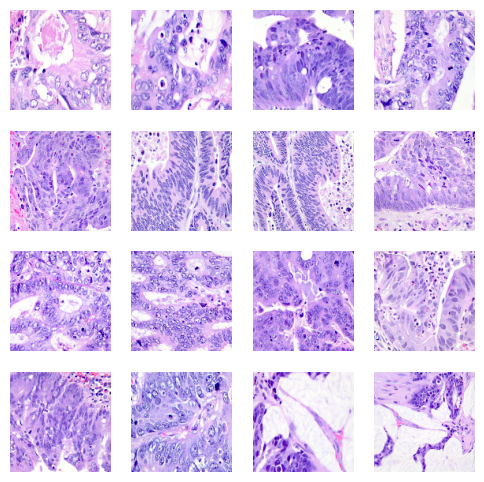

| It: 1 | Loss: -42.8129 | Time:   0.34s |


| It: 1001 | Loss: -60.8721 | Time: 352.13s |


| It: 2001 | Loss: -61.3383 | Time: 355.18s |


| It: 3001 | Loss: -61.5237 | Time: 352.85s |


| It: 4001 | Loss: -61.6172 | Time: 346.11s |


| It: 5001 | Loss: -61.6872 | Time: 347.76s |


| It: 6001 | Loss: -61.7366 | Time: 350.31s |


| It: 7001 | Loss: -61.7746 | Time: 349.26s |


| It: 8001 | Loss: -61.7992 | Time: 346.51s |


| It: 9001 | Loss: -61.8118 | Time: 350.99s |


| It: 1 | Loss: -42.0400 | Time:   0.35s |


| It: 1001 | Loss: -60.6158 | Time: 354.00s |


| It: 2001 | Loss: -61.2092 | Time: 349.29s |


| It: 3001 | Loss: -61.4243 | Time: 350.24s |


| It: 4001 | Loss: -61.5537 | Time: 350.71s |


| It: 5001 | Loss: -61.6423 | Time: 353.32s |


| It: 6001 | Loss: -61.7011 | Time: 357.09s |


| It: 7001 | Loss: -61.7456 | Time: 353.13s |


| It: 8001 | Loss: -61.7759 | Time: 356.37s |


| It: 9001 | Loss: -61.7909 | Time: 352.54s |


| It: 1 | Loss: -43.0943 | Time:   0.41s |


| It: 1001 | Loss: -60.5811 | Time: 351.97s |


| It: 2001 | Loss: -61.1790 | Time: 348.29s |


| It: 3001 | Loss: -61.4089 | Time: 352.43s |


| It: 4001 | Loss: -61.5292 | Time: 352.21s |


| It: 5001 | Loss: -61.6210 | Time: 351.35s |


| It: 6001 | Loss: -61.6844 | Time: 352.06s |


| It: 7001 | Loss: -61.7326 | Time: 351.40s |


| It: 8001 | Loss: -61.7644 | Time: 350.70s |


| It: 9001 | Loss: -61.7791 | Time: 353.40s |


| It: 1 | Loss: -41.7373 | Time:   0.38s |


| It: 1001 | Loss: -60.8577 | Time: 341.83s |


| It: 2001 | Loss: -61.3249 | Time: 347.39s |


| It: 3001 | Loss: -61.5055 | Time: 346.58s |


| It: 4001 | Loss: -61.6095 | Time: 352.56s |


| It: 5001 | Loss: -61.6797 | Time: 350.94s |


| It: 6001 | Loss: -61.7315 | Time: 352.54s |


| It: 7001 | Loss: -61.7701 | Time: 350.49s |


| It: 8001 | Loss: -61.7959 | Time: 345.81s |


| It: 9001 | Loss: -61.8080 | Time: 351.83s |


| It: 1 | Loss: -44.4383 | Time:   0.38s |


| It: 1001 | Loss: -60.6024 | Time: 350.68s |


| It: 2001 | Loss: -61.2448 | Time: 353.74s |


| It: 3001 | Loss: -61.4627 | Time: 351.72s |


| It: 4001 | Loss: -61.5789 | Time: 350.91s |


| It: 5001 | Loss: -61.6542 | Time: 352.29s |


| It: 6001 | Loss: -61.7123 | Time: 349.51s |


| It: 7001 | Loss: -61.7540 | Time: 352.42s |


| It: 8001 | Loss: -61.7837 | Time: 352.37s |


| It: 9001 | Loss: -61.7982 | Time: 353.00s |


BEST PSNR: 14.1712
MEDIAN PSNR: 12.9844
ALL PSNR: [12.5990, 12.7879, 14.1712, 13.0733, 13.0733]


<Figure size 400x300 with 0 Axes>

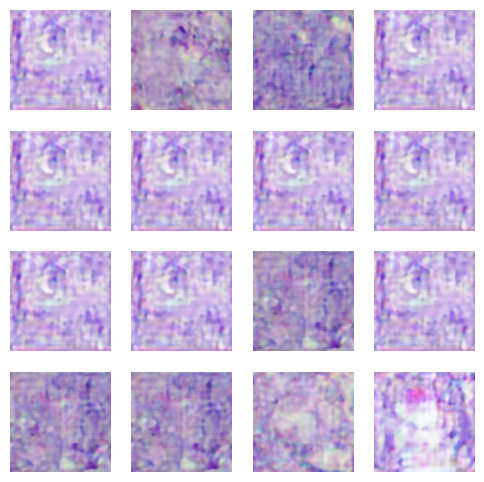

In [5]:
model = get_resnet18().to(device)
loss_func = torch.nn.CrossEntropyLoss()
data, label = next(loader_iter)
data, label = data.to(device), label.to(device)
client_grads = get_client_gradient(data, label, model, torch.nn.CrossEntropyLoss())
client_grads = [grad.clone() for grad in client_grads]
print(f"True Data:")
plot_images(data)

data = upscale(data)
best_ones_PSNR = torch.zeros_like(data)
best_ones_SSIM = torch.zeros_like(data)
best_ones_LPIPS = torch.zeros_like(data)
psnrs = []

for _ in range(5): # restart for better attack performance.
    recovered_images = FedLeak(client_grads, label, model, combine_loss, device=device)
    psnr = compute_psnr(data, recovered_images, False).mean().item()
    psnrs.append(psnr)
    best_ones_PSNR = update_best_ones(best_ones_PSNR, data, recovered_images, "PSNR")

print_psnrs(psnrs)
plot_images(best_ones_PSNR)

#### ⭕ 3.3 Times 3

True Data:


<Figure size 400x300 with 0 Axes>

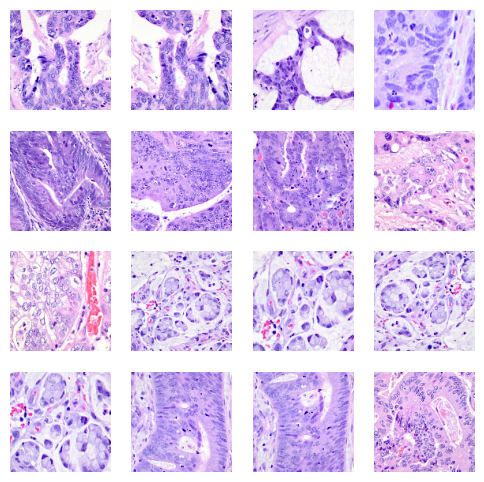

| It: 1 | Loss: -41.4007 | Time:   0.35s |


| It: 1001 | Loss: -60.7283 | Time: 351.64s |


| It: 2001 | Loss: -61.2633 | Time: 352.47s |


| It: 3001 | Loss: -61.4735 | Time: 349.83s |


| It: 4001 | Loss: -61.5831 | Time: 345.51s |


| It: 5001 | Loss: -61.6576 | Time: 350.40s |


| It: 6001 | Loss: -61.7158 | Time: 348.52s |


| It: 7001 | Loss: -61.7571 | Time: 351.79s |


| It: 8001 | Loss: -61.7848 | Time: 352.64s |


| It: 9001 | Loss: -61.7977 | Time: 350.32s |


| It: 1 | Loss: -42.8475 | Time:   0.38s |


| It: 1001 | Loss: -60.6191 | Time: 349.11s |


| It: 2001 | Loss: -61.2132 | Time: 351.76s |


| It: 3001 | Loss: -61.4391 | Time: 350.73s |


| It: 4001 | Loss: -61.5676 | Time: 351.79s |


| It: 5001 | Loss: -61.6480 | Time: 350.93s |


| It: 6001 | Loss: -61.7070 | Time: 343.54s |


| It: 7001 | Loss: -61.7506 | Time: 350.38s |


| It: 8001 | Loss: -61.7808 | Time: 350.59s |


| It: 9001 | Loss: -61.7951 | Time: 349.89s |


| It: 1 | Loss: -42.9969 | Time:   0.38s |


| It: 1001 | Loss: -60.6281 | Time: 350.53s |


| It: 2001 | Loss: -61.2365 | Time: 349.27s |


| It: 3001 | Loss: -61.4292 | Time: 350.40s |


| It: 4001 | Loss: -61.5592 | Time: 351.78s |


| It: 5001 | Loss: -61.6346 | Time: 348.81s |


| It: 6001 | Loss: -61.7007 | Time: 348.04s |


| It: 7001 | Loss: -61.7466 | Time: 345.04s |


| It: 8001 | Loss: -61.7779 | Time: 349.36s |


| It: 9001 | Loss: -61.7903 | Time: 352.04s |


| It: 1 | Loss: -44.6068 | Time:   0.40s |


| It: 1001 | Loss: -60.4399 | Time: 352.39s |


| It: 2001 | Loss: -61.1537 | Time: 352.04s |


| It: 3001 | Loss: -61.4330 | Time: 353.11s |


| It: 4001 | Loss: -61.5505 | Time: 352.89s |


| It: 5001 | Loss: -61.6393 | Time: 351.73s |


| It: 6001 | Loss: -61.7009 | Time: 363.99s |


| It: 7001 | Loss: -61.7467 | Time: 356.31s |


| It: 8001 | Loss: -61.7754 | Time: 361.00s |


| It: 9001 | Loss: -61.7897 | Time: 366.96s |


| It: 1 | Loss: -42.3977 | Time:   0.35s |


| It: 1001 | Loss: -60.4724 | Time: 367.17s |


| It: 2001 | Loss: -61.1961 | Time: 366.64s |


| It: 3001 | Loss: -61.3859 | Time: 362.96s |


| It: 4001 | Loss: -61.5474 | Time: 363.45s |


| It: 5001 | Loss: -61.6295 | Time: 362.52s |


| It: 6001 | Loss: -61.6954 | Time: 361.38s |


| It: 7001 | Loss: -61.7415 | Time: 363.13s |


| It: 8001 | Loss: -61.7732 | Time: 361.11s |


| It: 9001 | Loss: -61.7868 | Time: 361.28s |


BEST PSNR: 13.2722
MEDIAN PSNR: 12.1667
ALL PSNR: [12.4390, 11.1093, 11.5835, 12.4293, 12.4293]


<Figure size 400x300 with 0 Axes>

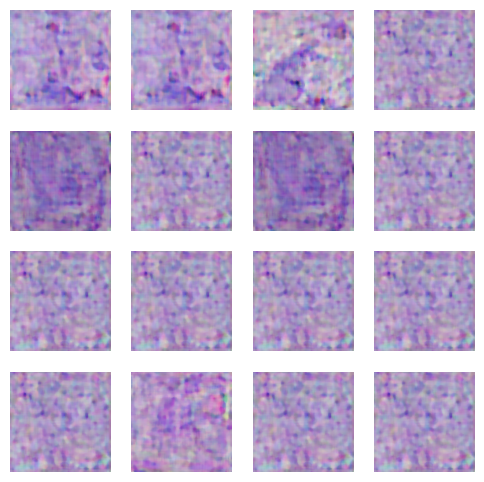

In [6]:
model = get_resnet18().to(device)
loss_func = torch.nn.CrossEntropyLoss()
data, label = next(loader_iter)
data, label = data.to(device), label.to(device)
client_grads = get_client_gradient(data, label, model, torch.nn.CrossEntropyLoss())
client_grads = [grad.clone() for grad in client_grads]
print(f"True Data:")
plot_images(data)

data = upscale(data)
best_ones_PSNR = torch.zeros_like(data)
best_ones_SSIM = torch.zeros_like(data)
best_ones_LPIPS = torch.zeros_like(data)
psnrs = []

for _ in range(5): # restart for better attack performance.
    recovered_images = FedLeak(client_grads, label, model, combine_loss, device=device)
    psnr = compute_psnr(data, recovered_images, False).mean().item()
    psnrs.append(psnr)
    best_ones_PSNR = update_best_ones(best_ones_PSNR, data, recovered_images, "PSNR")

print_psnrs(psnrs)
plot_images(best_ones_PSNR)

#### ⭕ 3.4 Times 4

True Data:


<Figure size 400x300 with 0 Axes>

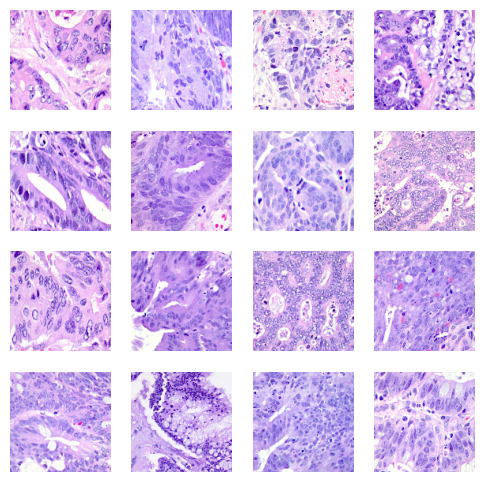

| It: 1 | Loss: -44.0138 | Time:   0.35s |


| It: 1001 | Loss: -60.7035 | Time: 363.19s |


| It: 2001 | Loss: -61.2472 | Time: 359.92s |


| It: 3001 | Loss: -61.4649 | Time: 357.08s |


| It: 4001 | Loss: -61.5790 | Time: 358.14s |


| It: 5001 | Loss: -61.6485 | Time: 359.77s |


| It: 6001 | Loss: -61.7036 | Time: 359.02s |


| It: 7001 | Loss: -61.7473 | Time: 362.10s |


| It: 8001 | Loss: -61.7756 | Time: 362.74s |


| It: 9001 | Loss: -61.7909 | Time: 361.90s |


| It: 1 | Loss: -42.0157 | Time:   0.39s |


| It: 1001 | Loss: -60.5442 | Time: 363.36s |


| It: 2001 | Loss: -61.2115 | Time: 362.36s |


| It: 3001 | Loss: -61.4022 | Time: 362.46s |


| It: 4001 | Loss: -61.5467 | Time: 360.56s |


| It: 5001 | Loss: -61.6305 | Time: 361.59s |


| It: 6001 | Loss: -61.6861 | Time: 360.44s |


| It: 7001 | Loss: -61.7367 | Time: 356.14s |


| It: 8001 | Loss: -61.7649 | Time: 355.57s |


| It: 9001 | Loss: -61.7811 | Time: 354.76s |


| It: 1 | Loss: -44.2399 | Time:   0.37s |


| It: 1001 | Loss: -60.5935 | Time: 358.74s |


| It: 2001 | Loss: -61.2354 | Time: 353.81s |


| It: 3001 | Loss: -61.4543 | Time: 358.32s |


| It: 4001 | Loss: -61.5715 | Time: 360.86s |


| It: 5001 | Loss: -61.6502 | Time: 357.92s |


| It: 6001 | Loss: -61.7100 | Time: 357.81s |


| It: 7001 | Loss: -61.7554 | Time: 357.67s |


| It: 8001 | Loss: -61.7832 | Time: 360.47s |


| It: 9001 | Loss: -61.7935 | Time: 359.48s |


| It: 1 | Loss: -41.6798 | Time:   0.39s |


| It: 1001 | Loss: -60.5196 | Time: 357.95s |


| It: 2001 | Loss: -61.2465 | Time: 358.72s |


| It: 3001 | Loss: -61.4624 | Time: 359.45s |


| It: 4001 | Loss: -61.5740 | Time: 360.18s |


| It: 5001 | Loss: -61.6533 | Time: 361.22s |


| It: 6001 | Loss: -61.7117 | Time: 361.77s |


| It: 7001 | Loss: -61.7543 | Time: 359.57s |


| It: 8001 | Loss: -61.7811 | Time: 358.37s |


| It: 9001 | Loss: -61.7959 | Time: 358.98s |


| It: 1 | Loss: -43.0603 | Time:   0.37s |


| It: 1001 | Loss: -60.4051 | Time: 358.79s |


| It: 2001 | Loss: -61.1274 | Time: 359.29s |


| It: 3001 | Loss: -61.3827 | Time: 359.93s |


| It: 4001 | Loss: -61.5312 | Time: 356.60s |


| It: 5001 | Loss: -61.6216 | Time: 360.01s |


| It: 6001 | Loss: -61.6842 | Time: 354.51s |


| It: 7001 | Loss: -61.7330 | Time: 360.74s |


| It: 8001 | Loss: -61.7651 | Time: 360.06s |


| It: 9001 | Loss: -61.7801 | Time: 361.09s |


BEST PSNR: 14.4136
MEDIAN PSNR: 13.4162
ALL PSNR: [13.0020, 13.6848, 14.4136, 12.1955, 12.1955]


<Figure size 400x300 with 0 Axes>

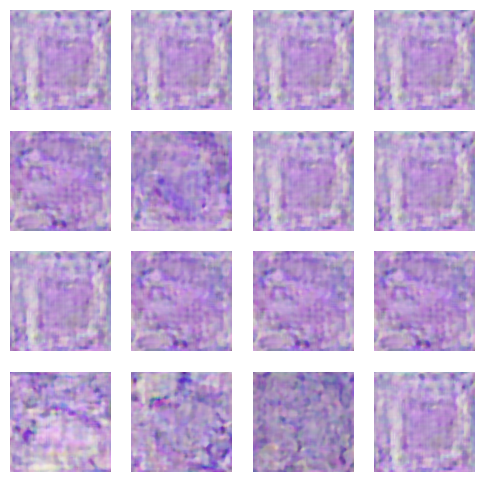

In [7]:
model = get_resnet18().to(device)
loss_func = torch.nn.CrossEntropyLoss()
data, label = next(loader_iter)
data, label = data.to(device), label.to(device)
client_grads = get_client_gradient(data, label, model, torch.nn.CrossEntropyLoss())
client_grads = [grad.clone() for grad in client_grads]
print(f"True Data:")
plot_images(data)

data = upscale(data)
best_ones_PSNR = torch.zeros_like(data)
best_ones_SSIM = torch.zeros_like(data)
best_ones_LPIPS = torch.zeros_like(data)
psnrs = []

for _ in range(5): # restart for better attack performance.
    recovered_images = FedLeak(client_grads, label, model, combine_loss, device=device)
    psnr = compute_psnr(data, recovered_images, False).mean().item()
    psnrs.append(psnr)
    best_ones_PSNR = update_best_ones(best_ones_PSNR, data, recovered_images, "PSNR")

print_psnrs(psnrs)
plot_images(best_ones_PSNR)

#### ⭕ 3.5 Times 5

True Data:


<Figure size 400x300 with 0 Axes>

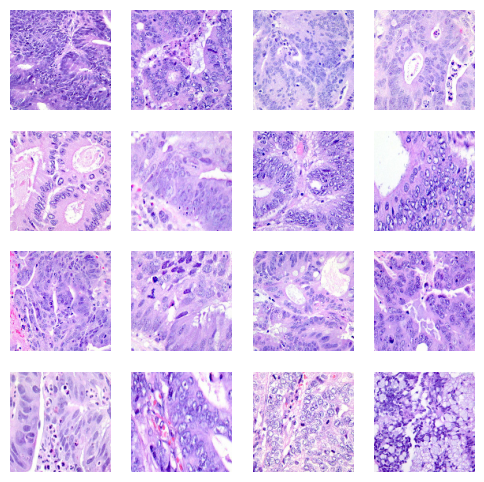

| It: 1 | Loss: -45.4473 | Time:   0.35s |


| It: 1001 | Loss: -60.8166 | Time: 358.68s |


| It: 2001 | Loss: -61.3663 | Time: 360.37s |


| It: 3001 | Loss: -61.5271 | Time: 359.99s |


| It: 4001 | Loss: -61.6286 | Time: 358.64s |


| It: 5001 | Loss: -61.6912 | Time: 358.98s |


| It: 6001 | Loss: -61.7470 | Time: 363.42s |


| It: 7001 | Loss: -61.7878 | Time: 357.39s |


| It: 8001 | Loss: -61.8119 | Time: 359.08s |


| It: 9001 | Loss: -61.8248 | Time: 357.66s |


| It: 1 | Loss: -45.5792 | Time:   0.39s |


| It: 1001 | Loss: -60.6794 | Time: 358.68s |


| It: 2001 | Loss: -61.2628 | Time: 357.64s |


| It: 3001 | Loss: -61.4894 | Time: 360.58s |


| It: 4001 | Loss: -61.5953 | Time: 357.74s |


| It: 5001 | Loss: -61.6740 | Time: 351.15s |


| It: 6001 | Loss: -61.7268 | Time: 359.65s |


| It: 7001 | Loss: -61.7712 | Time: 359.13s |


| It: 8001 | Loss: -61.7997 | Time: 360.19s |


| It: 9001 | Loss: -61.8121 | Time: 360.79s |


| It: 1 | Loss: -45.3153 | Time:   0.36s |


| It: 1001 | Loss: -60.7914 | Time: 362.79s |


| It: 2001 | Loss: -61.2960 | Time: 360.30s |


| It: 3001 | Loss: -61.5042 | Time: 355.94s |


| It: 4001 | Loss: -61.6185 | Time: 343.10s |


| It: 5001 | Loss: -61.6873 | Time: 343.42s |


| It: 6001 | Loss: -61.7449 | Time: 343.38s |


| It: 7001 | Loss: -61.7810 | Time: 336.14s |


| It: 8001 | Loss: -61.8085 | Time: 341.00s |


| It: 9001 | Loss: -61.8209 | Time: 335.30s |


| It: 1 | Loss: -46.3265 | Time:   0.27s |


| It: 1001 | Loss: -60.7873 | Time: 324.25s |


| It: 2001 | Loss: -61.3013 | Time: 343.52s |


| It: 3001 | Loss: -61.5076 | Time: 343.79s |


| It: 4001 | Loss: -61.6021 | Time: 345.28s |


| It: 5001 | Loss: -61.6793 | Time: 345.21s |


| It: 6001 | Loss: -61.7349 | Time: 345.25s |


| It: 7001 | Loss: -61.7776 | Time: 345.88s |


| It: 8001 | Loss: -61.8044 | Time: 344.58s |


| It: 9001 | Loss: -61.8170 | Time: 345.09s |


| It: 1 | Loss: -44.6519 | Time:   0.34s |


| It: 1001 | Loss: -60.7056 | Time: 345.36s |


| It: 2001 | Loss: -61.2661 | Time: 345.36s |


| It: 3001 | Loss: -61.4553 | Time: 343.98s |


| It: 4001 | Loss: -61.5846 | Time: 338.75s |


| It: 5001 | Loss: -61.6644 | Time: 337.84s |


| It: 6001 | Loss: -61.7205 | Time: 343.53s |


| It: 7001 | Loss: -61.7636 | Time: 343.94s |


| It: 8001 | Loss: -61.7920 | Time: 344.70s |


| It: 9001 | Loss: -61.8063 | Time: 345.92s |


BEST PSNR: 14.3726
MEDIAN PSNR: 12.8979
ALL PSNR: [12.6199, 13.0390, 14.3726, 12.1834, 12.1834]


<Figure size 400x300 with 0 Axes>

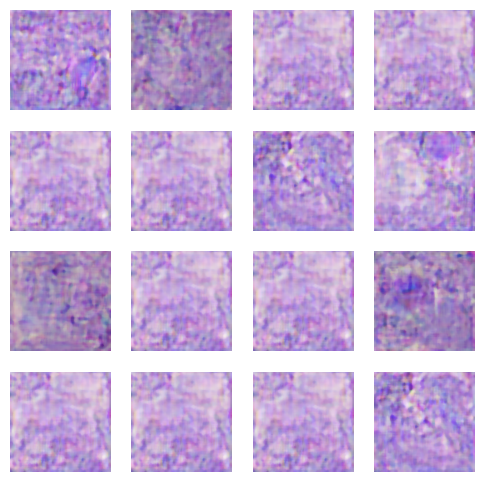

In [8]:
model = get_resnet18().to(device)
loss_func = torch.nn.CrossEntropyLoss()
data, label = next(loader_iter)
data, label = data.to(device), label.to(device)
client_grads = get_client_gradient(data, label, model, torch.nn.CrossEntropyLoss())
client_grads = [grad.clone() for grad in client_grads]
print(f"True Data:")
plot_images(data)

data = upscale(data)
best_ones_PSNR = torch.zeros_like(data)
best_ones_SSIM = torch.zeros_like(data)
best_ones_LPIPS = torch.zeros_like(data)
psnrs = []

for _ in range(5): # restart for better attack performance.
    recovered_images = FedLeak(client_grads, label, model, combine_loss, device=device)
    psnr = compute_psnr(data, recovered_images, False).mean().item()
    psnrs.append(psnr)
    best_ones_PSNR = update_best_ones(best_ones_PSNR, data, recovered_images, "PSNR")

print_psnrs(psnrs)
plot_images(best_ones_PSNR)